In [ ]:
library(caret)
library(randomForest)
library(tidymodels)

In [17]:
train <- read.csv(file = '../../Data/training_data.csv')
train <- subset(train,select = -SWEETORSOUR)
train$Intensity <- as.numeric(train$Intensity)
Y <- train$VALENCE.PLEASANTNESS
train <- subset(train,select = -VALENCE.PLEASANTNESS)

Remove correlated data; as we do not want to overfit, we remove variables that contains the "same informations"

In [19]:
train.Z <- subset(train,select = -nearZeroVar(train))
correlation <- cor(train.Z)
id <- sort(findCorrelation(correlation, cutoff=0.5))
data.unC <- train.Z[,-id]

[1]  708 2615

[1] 2615 2615

Intensity,ZM1,DECC,SMTIV,piPC06,VR1_D,SpMax_Dz.Z.,VR3_Dz.Z.,ATSC3i,ATSC5s,...,Psychotic.80,Psychotic.50,Hypertens.80,Hypertens.50,Hypnotic.80,Hypnotic.50,Neoplastic.80,Neoplastic.50,Infective.80,Infective.50
2,80,1.067,2454,4.190,15.566,47.917,1.788,0.933,23.627,...,0,0,1,0,1,0,1,0,1,0
1,40,0.938,630,3.876,8.678,15.012,0.845,0.353,7.007,...,0,0,0,0,0,0,0,0,0,0
1,86,1.222,4839,4.952,18.526,57.873,2.282,0.683,45.724,...,0,0,1,0,1,1,1,0,1,1
1,22,0.444,254,0.000,4.745,8.595,0.405,0.182,6.000,...,0,0,0,0,0,0,0,0,0,0
2,44,0.760,801,3.766,9.654,20.358,0.984,0.490,15.440,...,0,0,0,0,0,0,0,0,0,0
1,60,1.235,2514,3.797,13.574,46.628,1.586,0.643,17.250,...,0,0,0,0,1,0,1,0,1,0


Now our strategy, as CV did not work so well so far and it is very time consuming, is to have ntree very big, mtry and maxnode relatively small.
The reason for this is that we do not want to overfit data -> we would like low variance. A good way to reduce variance is to do RF with very big ntree.
The choice of mtry and max_node should be given by CV, we imagine it will be low, but not too low (too low mtry/max_node will result in high bias)

In [22]:
MSE.estimation <- function (Data,valid.split,p,ntree,mtry,maxnodes) {
    MSE <- c()
    for (i in 1:p){
        id <- sample(nrow(Data),nrow(Data)*0.8)
        train <- Data[id,]
        valid <- Data[-id,]
        RF <- randomForest(VALENCE.PLEASANTNESS ~ ., train, mtry = mtry, ntree = ntree, maxnodes = maxnodes)
        MSE <- append(MSE,mean((predict(RF,subset(valid,select = -VALENCE.PLEASANTNESS))-valid$VALENCE.PLEASANTNESS)^2))
        }
    mean(MSE)
}

In [25]:
data.unC$VALENCE.PLEASANTNESS <- Y  


In [26]:
MSE.estimation (data.unC, valid.split = 0.95, 15, ntree = 20000, mtry = 20, maxnodes = 40)

[1] 459.8305

It seems to work pritty well. Just to see; let s run a RF with the data uncorrelated and our optimized parameters form the first file (control)

In [31]:
MSE.estimation (data.unC, valid.split = 0.95, 15, ntree = 1800, mtry = 500, maxnodes = 20)

[1] 465.6487

### Let s start "recursive" CV finding (recursive is explained in the report)

We start with mtry CV and maxnodes = 30

In [27]:
fit_and_evaluate.mtry <- function(fold,ntree,iter,maxnodes) {      
    valid.set <- assessment(fold)
    sapply (iter, function (i) {
        tree <- randomForest(VALENCE.PLEASANTNESS ~ ., analysis(fold), mtry = i, ntree = ntree, maxnodes = maxnodes) 
        mean((valid.set$VALENCE.PLEASANTNESS-predict(tree,valid.set))^2)
    })
}


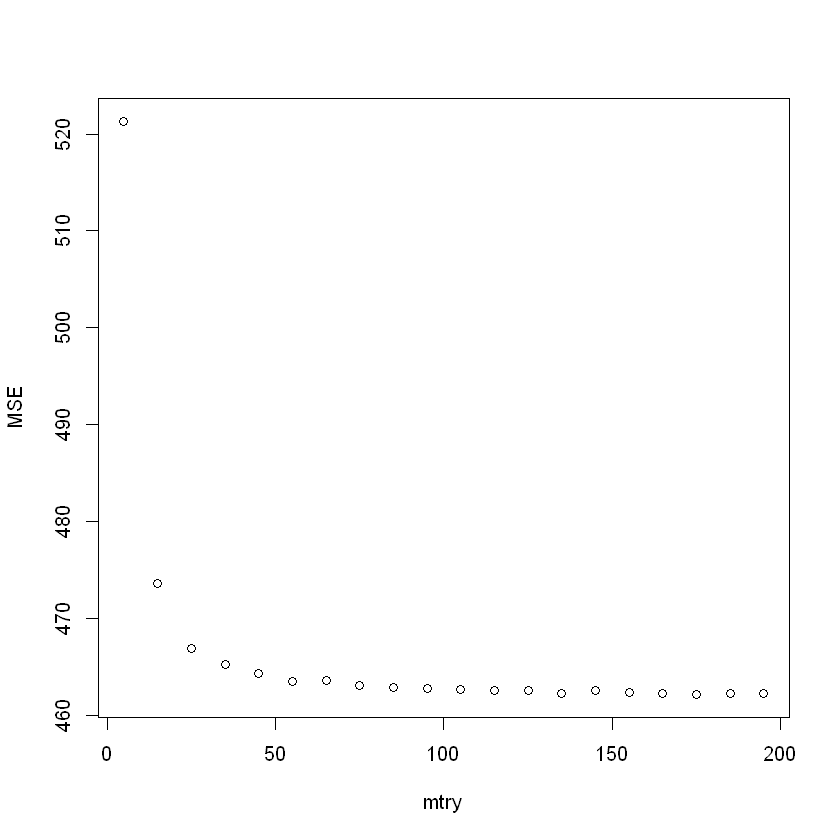

In [30]:
validation_data <- vfold_cv(data.unC, v = 10) 
iter <- seq(5,200, by = 10)
v.errors <- sapply(validation_data$splits, fit_and_evaluate.mtry, ntree = 15000, iter = iter, maxnodes = 30)
v.errors.maxnodes <- rowMeans(v.errors)
plot(iter,v.errors.maxnodes,xlab='mtry',ylab = 'MSE')

We see it is kind of the same graph as in the first file, we conclude that we can use mtry = 100

Then we CV maxnodes with the best mtry found previously: mtry = 100. We take a rather small mtry to increase the running time of the next CV. 

In [32]:
fit_and_evaluate.max <- function(fold,ntree,iter,mtry) {      
    valid.set <- assessment(fold)
    sapply (iter, function (i) {
        tree <- randomForest(VALENCE.PLEASANTNESS ~ ., analysis(fold), mtry = mtry, ntree = ntree, maxnodes = i) 
        mean((valid.set$VALENCE.PLEASANTNESS-predict(tree,valid.set))^2)
    })
}

In [ ]:
validation_data <- vfold_cv(data.unC, v = 10) 
iter <- seq(5,1000, by = 50)
v.errors <- sapply(validation_data$splits, fit_and_evaluate.max, ntree = 15000, iter = iter, mtry = 100)
v.errors.maxnodes <- rowMeans(v.errors)
plot(iter,v.errors.maxnodes,xlab='max Nodes',ylab = 'MSE')

Warning message in randomForest.default(m, y, ...):
"maxnodes exceeds its max value."Warning message in randomForest.default(m, y, ...):
"maxnodes exceeds its max value."Warning message in randomForest.default(m, y, ...):
"maxnodes exceeds its max value."Warning message in randomForest.default(m, y, ...):
"maxnodes exceeds its max value."Warning message in randomForest.default(m, y, ...):
"maxnodes exceeds its max value."Warning message in randomForest.default(m, y, ...):
"maxnodes exceeds its max value."Warning message in randomForest.default(m, y, ...):
"maxnodes exceeds its max value."Warning message in randomForest.default(m, y, ...):
"maxnodes exceeds its max value."Warning message in randomForest.default(m, y, ...):
"maxnodes exceeds its max value."Warning message in randomForest.default(m, y, ...):
"maxnodes exceeds its max value."Warning message in randomForest.default(m, y, ...):
"maxnodes exceeds its max value."Warning message in randomForest.default(m, y, ...):
"maxnodes exc